# Tokens cleaning and topic modelling

In [1]:

import sys
sys.path.append("..")

from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from src.dataset import Dataset
from src.tokenizers import BatchTokenizer
from src.vectorizers import TokenTfidfVectorizer

## Tokens analysis and cleaning

We start by loading the tokens and by plotting the document length.

In [2]:
dataset = Dataset(dataset_path="", save_path=f"../data/processed/tokenized_processed.json")
tokens = dataset.load_text_list(field_name="tokens", size=-1)

In [69]:
x = [len(x) for x in tokens]

fun = [max, min, np.mean, np.std]

print("Length stats:")
pprint([(f.__name__, f(x)) for f in fun])

Length stats:
[('max', 27266),
 ('min', 0),
 ('mean', 897.4436938559213),
 ('std', 952.6769893631284)]


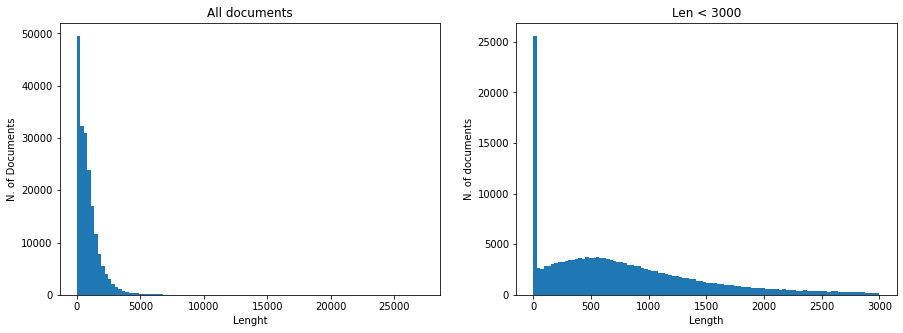

In [4]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(x, bins=100)
axs[1].hist(list(filter(lambda x:x<3000, x)), bins=100)
axs[0].set(title= "All documents", 
           xlabel="Lenght", ylabel="N. of Documents")
axs[1].set(title= "Len < 3000", 
           xlabel="Lenght", ylabel="N. of Documents")

plt.xlabel("Length")
plt.ylabel("N. of documents")
plt.show()

Apart from some excessively long documents, most of the documents are in the 0-5000 length range. The longest one may requires some investigation.

In [71]:
print(f"Index of longest document: {np.argmax(x)}")

Index of longest document: 193868


### Zipf curve

We start by computing the document frequency for each token, we can clearly see some tokens are heavily used, mean and max are really distant.

In [105]:
freqs = defaultdict(lambda:0)

for doc in tokens:
    for t in set(doc):
        freqs[t] += 1

f = list(freqs.values())

In [106]:
print("Terms frequency stats:")
pprint([(g.__name__, g(f)) for g in fun])

Terms frequency stats:
[('max', 180590),
 ('min', 1),
 ('mean', 138.16451797044812),
 ('std', 2286.117048500945)]


We now consider terms that appear in at least the 1 percent of documents. 

In [115]:
s_f = list(filter(lambda x : x >= len(tokens)*0.01, f))
print("Filtered terms frequency stats:")
pprint([(g.__name__, g(s_f)) for g in fun])

Filtered terms frequency stats:
[('max', 180590),
 ('min', 1944),
 ('mean', 14031.021150374001),
 ('std', 20444.439152469593)]


In [129]:
print(f"The most common term appears in the {round(max(s_f)/len(tokens), 2)}% of documents.")
print(f"There are {len(list(filter(lambda x : x<=0.1*len(tokens), f)))} terms that appear in less than 1% of documents ({int(0.1*len(tokens))}).")

The most common term appears in the 0.93% of documents.
There are 454690 terms that appear in less than 1% of documents (19436).


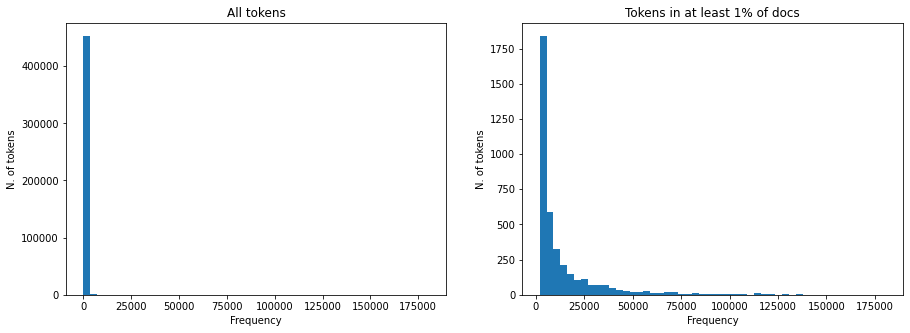

In [131]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(f, bins=50)
axs[1].hist(s_f, bins=50)
axs[0].set(title= "All tokens", 
           xlabel="Frequency", ylabel="N. of tokens")
axs[1].set(title= "Tokens in at least 1% of docs", 
           xlabel="Frequency", ylabel="N. of tokens")

plt.show()

## Topic modelling

### Vectorization

In [5]:
dv = TokenTfidfVectorizer(tokens)

vectors = dv.vectors()
dv.save_vectors_vectorizer(vectors)

print(f"Vocabulary length: {len(dv.vectorizer.vocabulary_)}")

Vocabulary length: 455470


### Vectors loading
Loading of previusly computed vectors, to avoid recomputing

In [2]:
vectors, vectorizer = TokenTfidfVectorizer.load_vectors_vectorizer()

## Guided LDA model definition

We start by setting the priors, then fit the model.

In [79]:
# ...